In [3]:
#loading the dataset

In [4]:
import zipfile
import os

path = '/content/drive/MyDrive/archive (16).zip'
extract_path = '/content/ex_images'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

['Fruit And Vegetable Diseases Dataset']

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle

In [6]:
# List of fruits and their categories
columns = [
    'Apple__Healthy', 'Apple__Rotten',
    'Banana__Healthy', 'Banana__Rotten',
    'Bellpepper__Healthy', 'Bellpepper__Rotten',
    'Carrot__Healthy', 'Carrot__Rotten',
    'Cucumber__Healthy', 'Cucumber__Rotten',
    'Grape__Healthy', 'Grape__Rotten',
    'Guava__Healthy', 'Guava__Rotten',
    'Jujube__Healthy', 'Jujube__Rotten',
    'Mango__Healthy', 'Mango__Rotten',
    'Orange__Healthy', 'Orange__Rotten',
    'Pomegranate__Healthy', 'Pomegranate__Rotten',
    'Potato__Healthy', 'Potato__Rotten',
    'Strawberry__Healthy', 'Strawberry__Rotten',
    'Tomato__Healthy', 'Tomato__Rotten'
]

In [7]:
# Function to load and preprocess images for a specific category
def load_images(category_path, img_size=100):
    images = []
    labels = []

    for img in os.listdir(category_path):
        image = cv2.imread(os.path.join(category_path, img))
        image = cv2.resize(image, (img_size, img_size))
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image_gray)
        labels.append(1 if 'Rotten' in category_path else 0)  # Assign label 1 for Rotten, 0 for Healthy

    return images, labels


In [8]:
# Function to extract HOG features from images
def extract_hog_features(images):
    hog_features = []
    for image in images:
        feature, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)
        hog_features.append(feature)
    return np.array(hog_features)


In [9]:
# Function to allow user to select a fruit type
def select_fruit_type():
    print("Select a fruit type:")
    for idx, fruit in enumerate(set([col.split('__')[0] for col in columns])):
        print(f"{idx+1}. {fruit}")

    choice = input("Enter the number corresponding to the fruit type: ")
    fruit_index = int(choice) - 1
    fruits = list(set([col.split('__')[0] for col in columns]))

    if 0 <= fruit_index < len(fruits):
        fruit = fruits[fruit_index]
        return [col for col in columns if col.startswith(fruit)]
    else:
        print("Invalid choice.")
        return None


In [11]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Select a fruit type:
1. Guava
2. Orange
3. Jujube
4. Banana
5. Grape
6. Cucumber
7. Carrot
8. Pomegranate
9. Potato
10. Tomato
11. Bellpepper
12. Strawberry
13. Apple
14. Mango
Enter the number corresponding to the fruit type: 1


<ipython-input-8-99235a08c552>:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)


Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        44
           1       0.86      0.89      0.88        36

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80



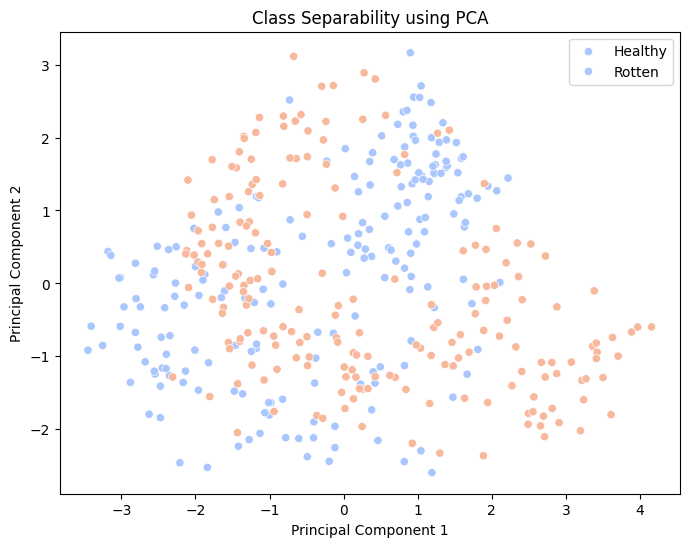

In [14]:
# Main script for interactive selection, training, and testing
if __name__ == "__main__":
    # Ask user to select a fruit type
    selected_categories = select_fruit_type()
    if not selected_categories:
        exit()

    # Load images for the selected fruit type
    base_path = '/content/ex_images/Fruit And Vegetable Diseases Dataset'
    images = []
    labels = []
    for category in selected_categories:
        category_path = os.path.join(base_path, category)
        category_images, category_labels = load_images(category_path)
        images.extend(category_images)
        labels.extend(category_labels)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Normalize images
    images = images.astype(float) / 255

    # Extract HOG features
    hog_features = extract_hog_features(images)

    # Dimensionality reduction using PCA
    pca = PCA(n_components=50)
    hog_features_pca = pca.fit_transform(hog_features)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(hog_features_pca, labels, test_size=0.2, random_state=42)

    # Initialize SVM model
    svm_model = SVC(kernel='linear', random_state=42)

    # Train the SVM model
    svm_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = svm_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Generate classification report
    print(classification_report(y_test, y_pred))

    # Visualize class separability
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=hog_features_pca[:, 0], y=hog_features_pca[:, 1], hue=labels, palette='coolwarm')
    plt.title('Class Separability using PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(['Healthy', 'Rotten'])
    plt.show()

    # # Allow user to test the model with a custom image
    # test_image_path = input("Enter the path to your test image: ")
    # if os.path.exists(test_image_path):
    #     test_image = cv2.imread(test_image_path)
    #     test_image = cv2.resize(test_image, (100, 100))  # Resize to match training size
    #     test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    #     test_image_normalized = test_image_gray.astype(float) / 255
    #     test_image_hog = extract_hog_features([test_image_normalized])
    #     test_image_pca = pca.transform(test_image_hog)

    #     # Predict using the trained model
    #     prediction = svm_model.predict(test_image_pca)

    #     # Print the prediction
    #     if prediction == 0:
    #         print("Predicted: Healthy")
    #     elif prediction == 1:
    #         print("Predicted: Rotten")
    #     else:
    #         print("Unknown prediction")
    # else:
    #     print("Invalid image path.")
